In [1]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib.image as image
import pandas as pd
from matplotlib.colors import LogNorm
import matplotlib.patches as patches

In [2]:
info = np.loadtxt('E_field/info.txt')
convert_dist=info[1] 
convert_E=info[2]
convert_vel=info[3]

# Load the csv file
df = pd.read_csv('E_field/Fields.csv')

# Convert the DataFrame to a numpy array
Field = df.values
r=Field[:,0]*convert_dist # r initial condition in (m)
z=Field[:,1]*convert_dist # z initial condition in (m)
Er=Field[:,2]*convert_E # Radial Electric Field Er in (V/m)
Ez=Field[:,3]*convert_E # Axial Electric Field Ez in (V/m)

E = np.sqrt(Er**2 + Ez**2)


R = np.loadtxt('E_field/r.txt')*convert_dist  #  in (m)
Z = np.loadtxt('E_field/z.txt')*convert_dist #  in (m)

In [3]:
print("r shape:", np.shape(r))
print("z shape:", np.shape(z))
print("Er shape:", np.shape(Er))
print("Ez shape:", np.shape(Ez))

r shape: (307083,)
z shape: (307083,)
Er shape: (307083,)
Ez shape: (307083,)


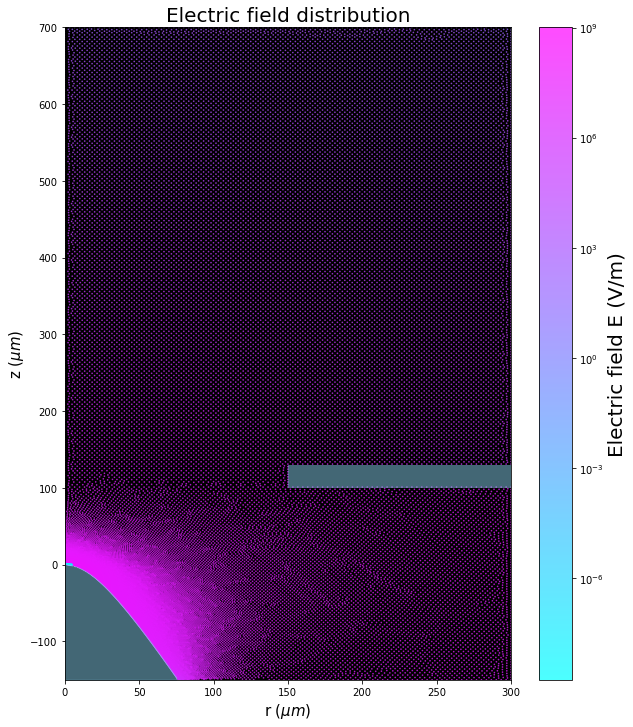

In [4]:


# Create a new figure with a black background
fig = plt.figure(figsize=(10,12), facecolor='white')
ax = fig.add_subplot(111, facecolor='black')

# Create a scatter plot
sc = ax.scatter(r*1e6, z*1e6, c=E, s=0.5, cmap='cool', norm=LogNorm(),alpha=0.7)

# Set the x and y limits to the minimum and maximum of the data
ax.set_xlim([r.min()*1e6, r.max()*1e6])
ax.set_ylim([z.min()*1e6, z.max()*1e6])

# Add a colorbar
cbar = plt.colorbar(sc)
cbar.set_label('Electric field E (V/m)', size=20, color='black')
cbar.ax.yaxis.set_tick_params(color='black')
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='black')

# Set plot title and labels
ax.set_title('Electric field distribution', size=20, color='black')
ax.set_xlabel('r ($\mu m$)', size=15, color='black')
ax.set_ylabel('z ($\mu m$)', size=15, color='black')
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')


#Plot the grid surface
#gold = image.imread('gold.jpg')

# Define the 4 points of the rectangle
p1 = (150, 100)
p2 = (150, 130)
p3 = (300, 100)
p4 = (300, 130)
width = p3[0]-p1[0]
height = p2[1]-p1[1]
# patches.Rectangle() needs the bottom left point, width and height
rect = patches.Rectangle((p1[0],p1[1]), width, height, facecolor ='skyblue', alpha=0.5)
# Add the patch to the Axes
ax.add_patch(rect)
#ax.imshow(gold, extent=(p1[0], p3[0], p1[1], p2[1]), aspect='auto')

#Plot the tip of the emitter
r_tip=np.arange(0,75,0.1)
d=100
Rc=11
eta0=np.power(1+Rc/d,-1/2)
a=2*d*np.sqrt(1+Rc/d)
z_tip=100-eta0*np.sqrt(np.power(a,2)/4+np.power(r_tip,2)/(1-np.power(eta0,2)))
plt.fill_between(r_tip, z_tip,-150, color='skyblue', alpha=0.5)

# Show the plot
plt.show()



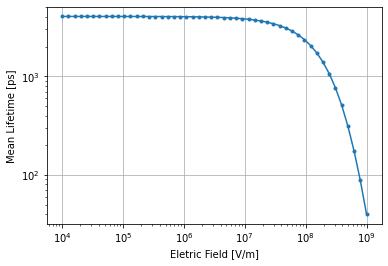

In [173]:
dt=5*1e-12

def frag_model(E):
    # Model 2
    dimer_poly = [-8.3804e-29,1.2457e-18,-5.7798e-09,8.3065]
    meanLifetime = np.exp(dimer_poly[0] * (E**3) + dimer_poly[1] * (E**2) + dimer_poly[2] * E + dimer_poly[3])
    return meanLifetime * (1e-12)  # ps -> s


pows = np.linspace(4, 9)
efield = np.power(10, pows)  # V/M
tau = np.asarray([frag_model(e) for e in efield])


plt.plot(efield, tau / 1e-12, '.-')
plt.xlabel("Eletric Field [V/m]")
plt.ylabel("Mean Lifetime [ps]")
plt.grid(True)
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.savefig("FragCurve.png")

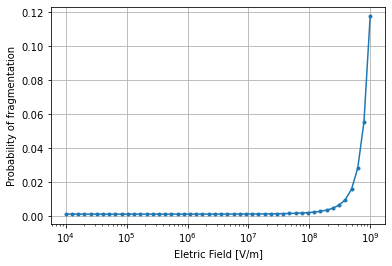

In [174]:
proba=1-np.exp(-dt/tau)
plt.plot(efield, proba, '.-')
plt.xlabel("Eletric Field [V/m]")
plt.ylabel("Probability of fragmentation")
plt.grid(True)
plt.gca().set_xscale("log")
plt.savefig("Proba_frag.png")

In [175]:
def prob_frag_compute(species,E_mag,dt):
    # Neutrals-->0 ; Primary Monomer-->1, Primary Dimer -->2 ; Primary Trimer -->3 ;
    # Secondary Monomer-->4, Secondary Dimer -->5 
    
    #E_mag = np.sqrt(E_array[:, 0]**2 + E_array[:, 1]**2)
    frag=np.zeros_like(E_mag)
    
    for i,spec in enumerate(species):
        
        if spec==0 or spec==1 or spec==4:
            #Neutral or Primary Monomer or Secondary Monomer
            tau=np.inf
        
        elif spec==2:
            #Primary Dimer
            c3, c2, c1, c0 = -8.3172e-29,1.267e-18,-6.108e-09,9.2724
            tau=np.exp(c3*E_mag[i]**3 + c2*E_mag[i]**2 + c1*E_mag[i] +c0)* (1e-12)  # ps -> s
        
        elif spec==3:
            #Primary Trimer
            c3, c2, c1, c0 = -3.5003e-29,7.7858e-19,-5.6108e-09,11.986
            tau=np.exp(c3*E_mag[i]**3 + c2*E_mag[i]**2 + c1*E_mag[i] +c0)* (1e-12)  # ps -> s

        elif spec==5:
            #Secondary Dimer
            c3, c2, c1, c0 = -8.3804e-29,1.2457e-18,-5.7798e-09,8.3065
            tau=np.exp(c3*E_mag[i]**3 + c2*E_mag[i]**2 + c1*E_mag[i] +c0)* (1e-12)  # ps -> s
            
        
        proba=1-np.exp(-dt/tau)
        frag[i]=proba
    
    return frag



2
3
5


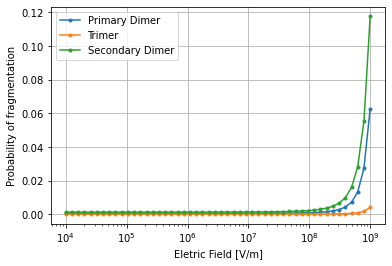

In [177]:
dt=5e-12
coeffs=np.array([2,3,5])
# Map coefficients to legend labels
label_map = {
    2: "Primary Dimer",
    3: "Trimer",
    5: "Secondary Dimer"
}

for coeff in coeffs:
    print(coeff)
    species=coeff*np.ones_like(efield)
    frag=prob_frag_compute(species,efield,dt)
    plt.plot(efield, frag , '.-',label=label_map[coeff])
    plt.xlabel("Eletric Field [V/m]")
    plt.ylabel("Probability of fragmentation")
    plt.grid(True)
    plt.gca().set_xscale("log")
    #plt.gca().set_yscale("log")
plt.legend()


In [178]:
amu2kg= 1.66053906660 *1e-27 # converts amu to kg
mass_list=np.array([197.973,111.168,309.141,507.114])*amu2kg  # mass in kg: neutral, monomer, dimer, trimer 
m_neutral=mass_list[0]
m_mono=mass_list[1]
m_dim=mass_list[2]
m_trim=mass_list[3]

def fragmentation_array(idx,species,masses,charges,pos,vel,acc,frag):
    # Neutrals-->0 ;
    # Primary Monomer-->1,
    # Primary Dimer -->2 ;
    # Primary Trimer -->3 ;
    # Secondary Monomer-->4,
    # Secondary Dimer -->5
    
    
    for i in range(len(frag)):
        # Generating 1 with a probability of frag[i] and 0 with a probability of 1-frag[i]
        # 1-> fragmentation; 0-> no fragmentation
        np.random.seed(0)
        fragmentation = np.random.choice([1, 0], p=[frag[i], 1-frag[i]])
        counter=0
        
        if fragmentation:
            
            counter=counter+1
            
            idx=np.append(idx,np.max(idx)+1)
            species=np.append(species,0)
            masses=np.append(masses,m_neutral)
            charges=np.append(charges,0)
            pos = np.vstack((pos, pos[i]))
            vel = np.vstack((vel, vel[i]))
            acc = np.vstack((acc, vel[i]))
            
            if species[i]==2:
                #if primary Dimer
                species[i]=4 # becomes secondary monomer
                masses[i]=m_mono
                
            elif species[i]==3:
                #if Trimer
                species[i]=5 # becomes secondary Dimer
                masses[i]=m_dim
                
            elif species[i]==5:
                #if Secondary Dimer
                species[i]=4 # becomes secondary monomer
                masses[i]=m_mono
                
            
        else:
            continue

    return idx,species,masses,charges,pos,vel,acc,counter

In [179]:
N = 5
np.random.seed(0)
idx = np.array([i+1 for i in range(N)])
species = np.array([0,1,2,3,4,5]) 
masses = np.array([m_neutral, m_mono, m_dim,m_trim,m_mono, m_dim])
charges = np.array([0,1,1,1,1,1])
pos = np.random.rand(N, 3)
vel = np.random.rand(N, 3)
acc = np.random.rand(N, 3)
frag = np.array([0.1, 0.3, 0.9, 0.5, 0.05])

In [181]:
idx,species,masses,charges,pos,vel,acc =fragmentation_array(idx,species,masses,charges,pos,vel,acc,frag)

0
0
1
Fragmentation happens for particle 2
0
0
